# Projekt Data Analytics
## Przewidywanie i analiza stanu cywilnego ludności USA na przestrzeni lat 

Autorzy: Julia Nowak, Adam Złocki

### 1. Sformuowanie problemu


##### Główny problem
Celem projektu jest predykcja ilości dorosłych osób po ślubie w społeczeństwie USA. Problem nie skupia się na konkretnych rasach ludzi – przyjęte zostały dane ogólne, wspólne dla wszystkich ras. Dobrany zestaw danych umożliwia jednak podzielenie danych na konkretne rasy oraz odrębną analizę stanu cywilnego. Idea projektu została oparta o aktualny temat dotyczący hipotetycznego spadku liczby małżeństw oraz wzrostu liczby rozwodów
w krajach wysoko rozwiniętych, takich jak USA. Podczas analizy chcemy wykazać istniejące trendy oraz przewidzieć rozkład interesujących nas wartości w przyszłości.

##### Przykłady użycia i powody analizy
Problem predykcji stanu cywilnego oraz przewidywanie ilości małżeństw w społeczeństwie jest z punktu widzenia państwa niezwykle istotną informacją.
Jest to problem, który warto analizować chociażby pod kątem planowania przez rząd Stanów Zjednoczonych polityki prorodzinnej. Temat jest istotny także przy wszelkiego rodzaju oszacowaniach związanych z przyrostem naturalnym czy uwarunkowaniami społecznymi. Analiza może wskazać rządowi ze znacznym wyprzedzeniem, iż w społeczeństwie zachodzą pewne zmiany, które warto wziąć pod uwagę przy tworzeniu przyszłych planów.

##### Pochodzenie i zawartość danych
Dane, które są przez nas wykorzystywane, pochodzą z oficjalnej strony rządowej USA (www.census.gov). Zawierają one informacje o liczbie osób o danym stanie cywilnym w zależności od roku, średnim wieku zawarcia pierwszego małżeństwa, ilości dostępnych na rynku mieszkań oraz o całkowitym, średnim przychodzie na członka gospodarstwa domowego w celu zaprezentowania ogólnej sytuacji materialnej społeczeństwa.
Dodatkowo dostępne są również identyczne dane z uwzględnieniem podziału na rasy,
a więc możliwe jest przeprowadzenie predykcji dla każdej z nich osobno, a następnie wykonanie analizy porównawczej, jednak nie zastosowaliśmy takiego podejścia.
Wykorzystywane przez nas dane są danymi historycznymi, uzupełnianymi od XX wieku do 2023 roku. Ich ostatnia aktualizacja miała miejsce w listopadzie 2023 roku – są to więc dane stosunkowo świeże. Do analizy przyjęte zostały lata 2020 – 2022, z pominięciem duplikatów niektórych lat (z każdej pary wybrano dane odświeżone).
Dane uwzględniają różne tabele pochodzące z Ankiet Obecnej Populacji (ang. Current Population Survey; CPS), przeprowadzanych co roku przez cenzus w USA.

##### Schemat DAG
Poniższy diagram DAG reprezentuje wykorzystane przez nas w projekcie zależności. Jako predyktory zastosowaliśmy średni przychód na członka gospodarstwa domowego, oraz ilość dostępnych na rynku mieszkań, dzięki czemu badaliśmy wpływ ogólnej sytuacji ekonomicznej społeczeństwa na ilość małżeństw.


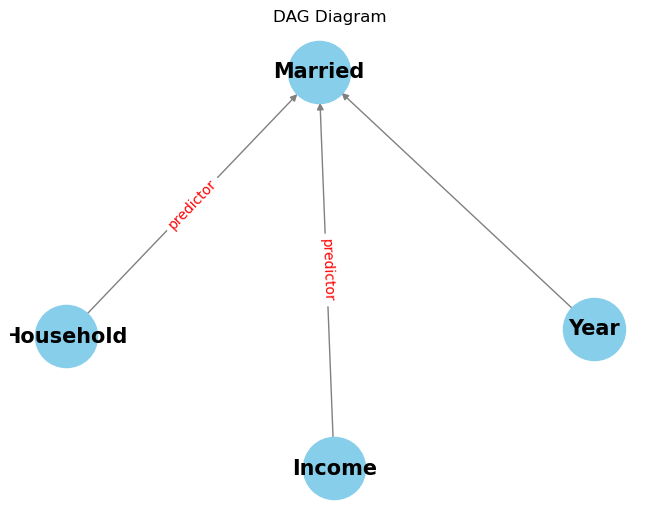

In [87]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Year")
G.add_node("Household")
G.add_node("Income")
G.add_node("Married")

# Add edges
G.add_edge("Year", "Married")
G.add_edge("Income", "Married")
G.add_edge("Household", "Married")

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=15, font_weight='bold')

# Add edge labels
edge_labels = {
    ("Income", "Married"): "predictor",
    ("Household", "Married"): "predictor"
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("DAG Diagram")
plt.show()


### 2. Preprocessing - wstępne przetwarzanie danych

1. Wybranie analizowanych lat oraz rasy:
- wybrano lata 1993 - 2022 (prawie 30 lat do analizy)
- lata 2018-2023 zostały przeznaczone do oceny działania modelu
- skupiono się na analizie ogólnej wszystkich ras łącznie

2. Uwagi do danych:
- w przypadku lat 2011 oraz 2021 w danych wystąpiły podwójne wyniki, ze względu na to, iż zaprezentowano wyniki pierwotne oraz zaktualizowane na podstawie populacji z ostatniego spisu powszechnego co dziesięciolecie (przyjęto zaktualizowane wartości)
- w roku 2014 nastąpiła zmiana pytań odnośnie przychodu, a więc część pytań zadanych ankietowanym się różniła
- od 2019 uwzględniono również małżeństwa homoseksualne

3. Usuwanie i operacje:
- rok zmieniono z "..2011" do formy bez kropek
- usunięto rok 2023 ze względu na przychód z lat poprzednich
- usunięto zduplikowane lata
- połączono dane tak, aby pominąć kwestię płci
- wyliczono całość badanych (z uzględnieniem danych spoza analizowanych)
- household wybrano z odrębnej bazy danych dla lepszych wyników
- przekształcenie lat na liczby, ujednolicenie typów danych


##### Import niezbędnych bibliotek

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


##### Odczyt danych z pliku łączonego

In [89]:
# Read from excel file
df_ac  = pd.read_excel("data.xlsx", sheet_name="Raw_data")

# Select only essential columns
df = df_ac[['Year', 'Married', 'Income per member', "Mean age", "Household", "Total"]]

##### Podział danych

In [90]:
# All data for testing purposes
df_all = df

# Selection of years - 5 years are left for checking results
df = df[:25]

# Quick look at the table
df.head()

,Year,Married,Income per member,Mean age,Household,Total
0,1993,114601,15500,25.50,96391,197254
1,1994,115253,16300,25.60,97107,200800
2,1995,116554,16940,25.70,98990,202732
3,1996,116561,17850,25.95,99627,204624
4,1997,116752,18940,25.90,101018,207235


##### Wstępna analiza danych

In [91]:
# Data for models
df.describe()

,Year,Married,Income per member,Mean age,Household,Total
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,2005.000000,125517.720000,24412.000000,26.690000,112143.720000,229046.720000
std,7.359801,6685.028917,5173.445821,0.941962,9520.963469,19449.196392
min,1993.000000,114601.000000,15500.000000,25.500000,96391.000000,197254.000000
25%,1999.000000,119040.000000,21060.000000,25.950000,103874.000000,211676.000000
50%,2005.000000,127142.000000,24670.000000,26.350000,113343.000000,230272.000000
75%,2011.000000,130767.000000,27330.000000,27.400000,119927.000000,245275.000000
max,2017.000000,135749.000000,34640.000000,28.450000,126224.000000,259063.000000


In [92]:
# Data for checking purposes
df_all.describe()

,Year,Married,Income per member,Mean age,Household,Total
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2007.500000,127399.333333,26878.666667,27.095000,114955.166667,235071.200000
std,8.803408,7444.099549,7382.727154,1.262069,10777.675445,22400.099328
min,1993.000000,114601.000000,15500.000000,25.500000,96391.000000,197254.000000
25%,2000.250000,120932.750000,22230.000000,26.000000,105581.000000,215089.250000
50%,2007.500000,129288.500000,26325.000000,26.650000,116397.000000,236920.500000
75%,2014.750000,133319.250000,30940.000000,28.150000,124247.500000,254318.000000
max,2022.000000,137772.000000,42330.000000,29.450000,131202.000000,268583.000000


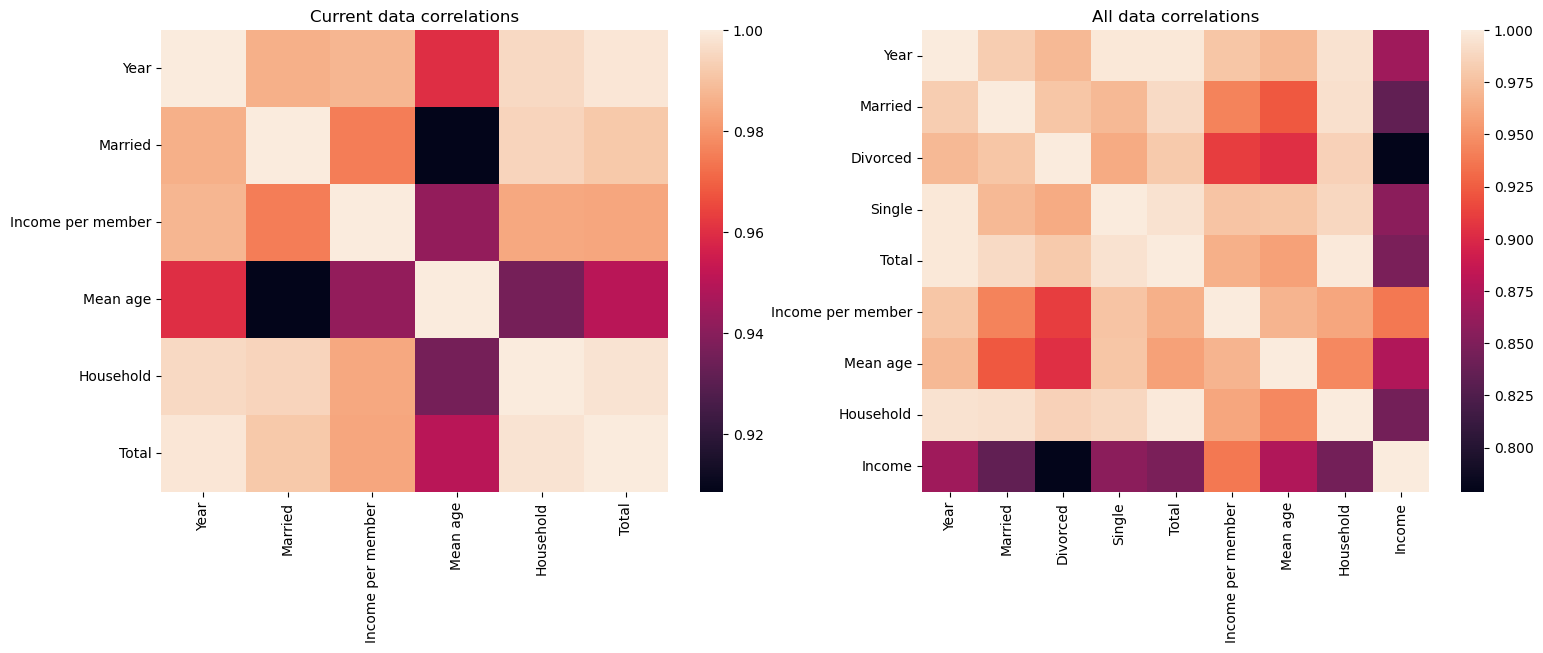

In [103]:
# Correlations

fig, ax =plt.subplots(1,2)

fig.set_size_inches(18, 6)

ax[0].set_title('Current data correlations')
sns.heatmap(df.corr(), ax=ax[0])

ax[1].set_title('All data correlations')
sns.heatmap(df_ac.corr(), ax=ax[1])

plt.show()


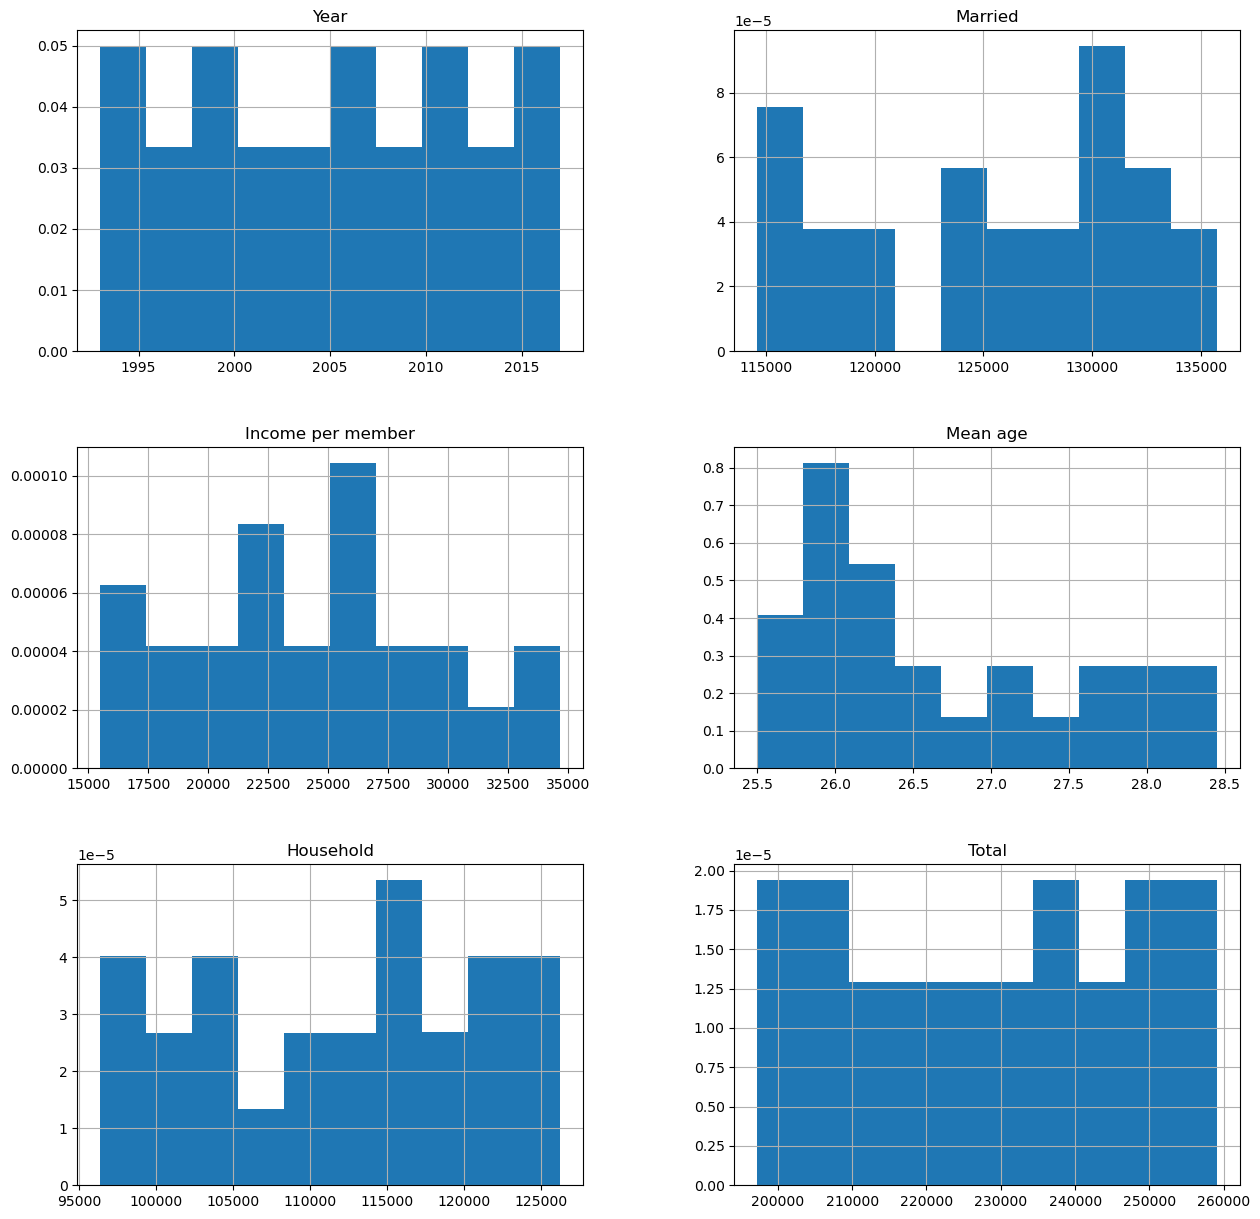

In [95]:
df.hist(figsize=(15,15), bins=10, density=True)
plt.show()

In [96]:
import warnings
import cmdstanpy
warnings.filterwarnings('ignore')
from cmdstanpy import CmdStanModel

import arviz as az
import scipy.stats as stats


### 3. Utworzenie modeli

- Utworzyliśmy dwa modele - jeden przewidujący liczbę osób po ślubie na podstawie danych o średnim przychodzie na jednego członka gospodarstwa domowego, oraz drugi - wykorzystujący dodatkowo liczbę dostępnych miejsc zamieszkania i średni wiek wejścia w pierwszy związek małżeński,

- Zastosowaliśmy drugi predyktor z nadzieją na to że poszerzenie kontekstu poprawi otrzymywane wyniki i uczyni je bardziej zbliżonymi do rzeczwistości,

- ??????are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt]

In [97]:
model_1_prior = CmdStanModel(stan_file='prior.stan')
model_1_posterior = CmdStanModel(stan_file='posterior.stan')
model_2_prior = CmdStanModel(stan_file='tri_prior.stan')
model_2_posterior = CmdStanModel(stan_file='tri_posterior.stan')

N = 25
R = 30

### 4. Priors

- Is it explained why particular priors for parameters were selected [1 pt]
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt]

In [98]:
data = {'N': N, 'income': df['Income per member']}
gen_1 = model_1_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

00:28:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


00:28:47 - cmdstanpy - INFO - CmdStan done processing.


In [99]:
gen_1.draws_pd()

,lp__,accept_stat__,alpha,beta,sigma,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,1.36833,96354.4,363.8660,117610.0,118153.0,119623.0,121215.0,123095.0,...,132869.0,132274.0,132493.0,133983.0,135088.0,136976.0,137248.0,138562.0,141258.0,143517.0
1,0.0,0.0,1.30723,94514.1,920.0090,115364.0,116217.0,114048.0,118800.0,119756.0,...,129539.0,127583.0,128503.0,129990.0,131911.0,133667.0,134140.0,134327.0,137372.0,139793.0
2,0.0,0.0,1.30859,96319.1,1369.8500,118216.0,119311.0,119569.0,120729.0,118866.0,...,129315.0,131678.0,133251.0,131625.0,130420.0,135758.0,135552.0,135992.0,140686.0,141617.0
3,0.0,0.0,1.27481,93623.4,1448.9200,114056.0,113217.0,114995.0,113639.0,116321.0,...,126038.0,126968.0,129143.0,128354.0,128789.0,129899.0,129919.0,135577.0,135152.0,137551.0
4,0.0,0.0,1.28421,95587.9,1441.3400,112428.0,116838.0,114093.0,117634.0,118647.0,...,128524.0,129962.0,130414.0,131389.0,129824.0,135225.0,134861.0,134208.0,139137.0,140184.0
5,0.0,0.0,1.25440,95516.4,1588.6000,115357.0,114750.0,118564.0,116937.0,119177.0,...,129235.0,126909.0,128203.0,128992.0,132839.0,131787.0,132627.0,133264.0,136298.0,140491.0
6,0.0,0.0,1.28807,96690.2,1200.1300,115455.0,115550.0,118715.0,118619.0,119441.0,...,132007.0,130187.0,131116.0,131732.0,132871.0,135483.0,137043.0,139486.0,141733.0,141598.0
7,0.0,0.0,1.25677,95355.2,615.7430,115384.0,116017.0,117177.0,118132.0,119254.0,...,128365.0,126763.0,128145.0,129220.0,130156.0,133541.0,133390.0,135025.0,137417.0,139193.0
8,0.0,0.0,1.29109,98321.7,1547.9300,118073.0,118255.0,121154.0,122357.0,123511.0,...,130221.0,131720.0,133099.0,131137.0,134658.0,134445.0,135174.0,138853.0,141658.0,141923.0
9,0.0,0.0,1.23215,92709.9,1588.1100,114305.0,114876.0,112422.0,114987.0,115828.0,...,123322.0,122590.0,124012.0,125391.0,128307.0,132825.0,129838.0,130084.0,134948.0,135123.0


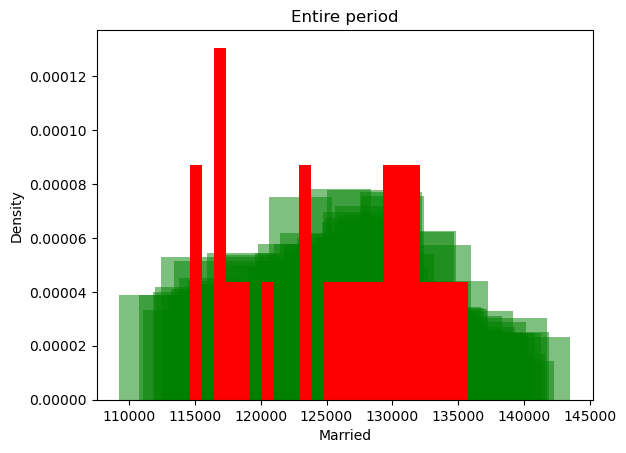

In [100]:
for i in range(R):
    plt.hist(gen_1.y_sim[i], bins=5, color='green', alpha = 0.5, density=True)
plt.hist(df['Married'], bins=23, color='red', density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.show()

### 5. Posterior (model 1) - analiza

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

### 6. Posterior (model 2) - analiza

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

### 7. Porównanie modeli

- Have models been compared using information criteria [1 pt]
- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]